In [27]:
# Standard library imports
import os
import json
import pandas as pd
import timm
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai.callback.core import Callback
import torch
import cv2
import numpy as np

In [28]:
# List all available models in timm
# Check CVT model
available_models = timm.list_models()
print(available_models)

['bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet_rmlp_2_rw_224', 'coatnet_rmlp_2

In [29]:
import os
import pandas as pd

# Define the path to your CSV file and training images
csv_path = os.path.join('COMP90086_2024_Project_train', 'train.csv')
train_dir = os.path.join('COMP90086_2024_Project_train', 'train')

# Read the CSV file into a DataFrame
train_data = pd.read_csv(csv_path)

# Add a column with the complete image path
train_data['image_path'] = train_data['id'].apply(lambda x: os.path.join(train_dir, f"{x}.jpg"))

# Ensure that the 'stable_height' column is treated as a string for classification
train_data['stable_height'] = train_data['stable_height'].astype(str)

In [30]:
"""
goal: to have 65+ accuracy and good visiualisations for report
maybe try 2 techniques /shrug



VisionTransformerTrainer / model
    model name
    self.lr = None
    self.metrics = {}
    self.dls = dls
    
dataload - todo Jule
    split into training and validation
    data loader build
        inceptionv4 uses 299 299

testcase
    - VisionTransformerTrainer /model
    - dataloader



        
 https://docs.fast.ai/tutorial.vision.html   

need
    data
        model name
        model class
        Learning rate
        metrics
            Error rate
            epoc
            training loss
            validation loss
            accuracy
    functions
        auto learning rate Jack
        save results in dataframe for easy loading Jack
        post trained model weight Jule
            save model every 5 epoc
        auto test with different techniques
            data augmentation
            active learning????
            Progressive Training (cross that bridge when we get to it)
                number of bricks can i train them on both?
                stability can i train them on both?
                stabel height
            
        load visiualisaion from json data

"""

'\ngoal: to have 65+ accuracy and good visiualisations for report\nmaybe try 2 techniques /shrug\n\n\n\nVisionTransformerTrainer / model\n    model name\n    self.lr = None\n    self.metrics = {}\n    self.dls = dls\n    \ndataload - todo Jule\n    split into training and validation\n    data loader build\n        inceptionv4 uses 299 299\n\ntestcase\n    - VisionTransformerTrainer /model\n    - dataloader\n\n\n\n        \n https://docs.fast.ai/tutorial.vision.html   \n\nneed\n    data\n        model name\n        model class\n        Learning rate\n        metrics\n            Error rate\n            epoc\n            training loss\n            validation loss\n            accuracy\n    functions\n        auto learning rate Jack\n        save results in dataframe for easy loading Jack\n        post trained model weight Jule\n            save model every 5 epoc\n        auto test with different techniques\n            data augmentation\n            active learning????\n            Prog

In [54]:
class SimpleBlur(Transform):
    def __init__(self, kernelSize=(5, 5)):
        self.kernelSize = kernelSize

    def encodes(self, img: PILImage):
        # Convert the image to a NumPy array for OpenCV processing
        img_np = np.array(img)
        # Apply simple blur using the specified kernel size
        blurred_img = cv2.blur(img_np, self.kernelSize)
        # Convert the blurred image back to a PIL Image
        return PILImage.create(blurred_img)

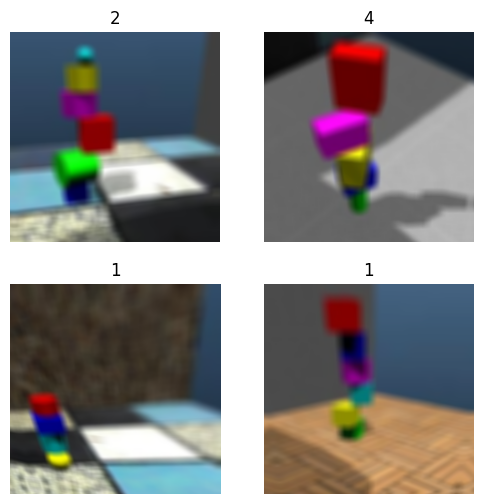

In [56]:
# Dataloader Objects

# Dataloader for vision transformers
# Resizes to 224
transformer_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Define the input and output types
    get_x=ColReader('image_path'),       # Read the image paths
    get_y=ColReader('stable_height'),    # Read the target labels
    splitter=RandomSplitter(valid_pct=0.2),  # Split into training and validation sets
    item_tfms=[Resize(224),SimpleBlur(kernelSize=(10,10))],   # Resize image and performs simple image blurring
    batch_tfms=aug_transforms()          # Apply data augmentation -  randomly performs image augmentation steps such as 90 degree rotation,adding noise, etc
)

transformer_dl = transformer_db.dataloaders(train_data, bs=8, num_workers=0)
transformer_dl.show_batch(max_n=4,figsize=(6,6))

In [24]:
## Class for utilizing the Callback function from fastai
# Define the callback within the function
class SaveEvery5EpochsCallback(Callback):
    def __init__(self, model_name):
        self.model_name = model_name
    
    def after_epoch(self):
        # Check if the current epoch is a multiple of 5
        if (self.epoch + 1) % 5 == 0:
            self.learn.save(f"{self.model_name}_epoch_{self.epoch + 1}")
            print(f"Model saved at epoch {self.epoch + 1} as {self.model_name}_epoch_{self.epoch + 1}")

    def after_train(self):
        # Ensure the model is saved at the final epoch
        self.learn.save(f"{self.model_name}_final")
        print(f"Model saved at the end of training as {self.model_name}_final")

In [25]:
from typing import Tuple

class VisionTransformerTrainer:
    def __init__(self, model_name='vit_base_patch16_224', dls=None):
        self.model_name = model_name
        self.learn = None
        self.lr = None
        self.metrics = {}
        self.dls = dls

        if self.dls is None:
            raise Exception("No dataloader provided. Please provide a dataloader when initializing the class.")
        else:
            print("Using provided dataloader.")

    def initialize_model(self, pretrained=True):
        self.model = timm.create_model(self.model_name, pretrained=pretrained, num_classes=self.dls.c)
        self.learn = vision_learner(self.dls, self.model_name, metrics=accuracy, pretrained=pretrained,cbs=CSVLogger())
        
        # Check if CUDA is available
        if torch.cuda.is_available():
            self.learn.model = self.learn.model.cuda()
            print("CUDA is available. Using GPU for training.")
        else:
            print("CUDA is not available. Using CPU for training.")

    def set_learning_rate(self):
        """
        Sets the learning rate automatically.
        
        Args:
            learning_rate (float): The learning rate to use for training.
        """
        def find_optimal_lr(learner) -> float:
            lr_learn: Tuple[float, float] = learner.lr_find(suggest_funcs=(minimum, steep))
            lr_min, lr_steep = lr_learn
            optimal: float = lr_steep / 5
            return optimal
        

        self.lr = find_optimal_lr(self.learn)
        print(f"Learning rate set to: {self.lr}")

    def fine_tune(self, epochs=5):
        """
        
        """
        if self.learn is None:
            raise Exception("Model has not been initialized. Please run initialize_model() first.")
        if self.lr is None:
            raise Exception("Learning rate not set. Please set it using set_learning_rate() first.")
        
        #This saves every 5 epochs automatically during fine-tuning
        self.learn.add_cb(SaveEvery5EpochsCallback(model_name=self.model_name.replace('/', '_')))
        
        self.learn.fine_tune(epochs, base_lr=self.lr)
        
        torch.cuda.empty_cache()

    def load_model(self, model_name=None):
        if self.learn is None:
            raise Exception("Model has not been initialized. Please run initialize_model() first.")
        
        if model_name is None:
            model_name = self.model_name.replace('/', '_')
        self.learn.load(model_name)
        print(f"Model loaded from {model_name}")

    def predict(self, image_path):
        if self.learn is None:
            raise Exception("Model has not been initialized. Please run initialize_model() first.")
        
        img = PILImage.create(image_path)
        pred, pred_idx, probs = self.learn.predict(img)
        return {'id': os.path.basename(image_path).split('.')[0], 'predicted_stable_height': pred, 'probability': probs[pred_idx].item()}

    def plot_metrics(self):
        pass

    def get_final_accuracy(self):
        """
        I theoretically could store it in a callback after each epoch, but would take 20min + to code
        """

        return self.learn.recorder.metrics[0].value.item()
    
    def get_training_metrics(self) -> pd.DataFrame:
        """
        Get training metrics from CSV log and save to self.
        
        Returns:
            pd.DataFrame: DataFrame containing training metrics
        """
        df: pd.DataFrame = self.learn.csv_logger.read_log()
        self.training_metrics: pd.DataFrame = df
        self.final_accuracy = final_accuracy = df['accuracy'].iloc[-1]
        self.final_epoch = final_epoch = df['epoch'].iloc[-1]
        return df
        
    def save_metrics(self):
        df = self.get_training_metrics()
        final_accuracy = self.final_accuracy
        final_epoch = self.final_epoch
        total_time = pd.to_timedelta(df['time'].apply(lambda x: f'00:{x}')).sum()
        
        metrics = {
            'model_name': self.model_name,
            'accuracy': f"{final_accuracy:.3f}",
            'epoch': f"{final_epoch:02d}",
            'total_time': f"{total_time.total_seconds():.0f}s"
        }
        
        file_name = f"acc{final_accuracy:.3f}_epo{final_epoch:02d}_tim{total_time.total_seconds():.0f}s_{self.model_name}.json"
        file_path = os.path.join('metrics', file_name)
        
        os.makedirs('metrics', exist_ok=True)
        with open(file_path, 'w') as f:
            json.dump(metrics, f, indent=4)
        
        print(f"Metrics saved to {file_path}")
        



Training with model: resnet34
Using provided dataloader.
CUDA is available. Using GPU for training.


Learning rate set to: 2.636513499965076e-07


epoch,train_loss,valid_loss,accuracy,time
0,3.199640,2.370616,0.172526,01:05


epoch,train_loss,valid_loss,accuracy,time
0,3.069654,2.387425,0.173828,01:29
1,3.233821,2.363381,0.173177,01:28
2,3.183750,2.404826,0.173828,01:28
3,3.149821,2.419267,0.164714,01:27
4,3.197560,2.381335,0.182292,01:28
5,3.105536,2.386159,0.177083,01:31


Model saved at epoch 5 as resnet34_epoch_5
Metrics saved to metrics\resnet34_metrics.json


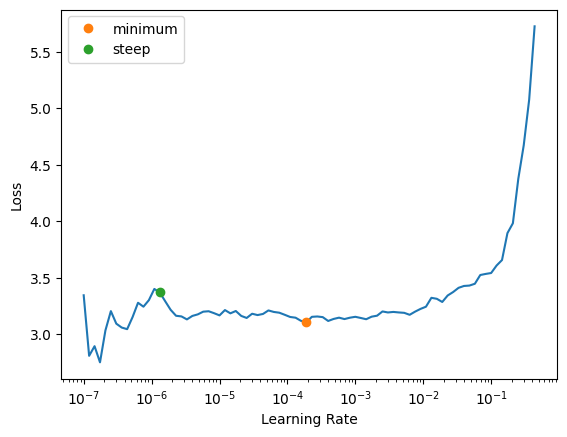

In [26]:
# List of Vision Transformer models to test from timm
model_names = [  
    # 'vit_base_patch16_224',     # Vanilla ViT model  
    # 'beit_base_patch16_224',    # BEiT model
    # 'cvt-21-224x224',           # CvT model
    # 'deit_base_patch16_224'     # DeiT model
    'efficientnet'
]

# Paths to your dataset
csv_path = 'COMP90086_2024_Project_train/train.csv'
train_dir = 'COMP90086_2024_Project_train/train'

# Define the learning rate to be used for all models
learning_rate = 3e-4  # You can adjust this value as needed

# Loop through each Vision Transformer model and train
for model_name in model_names:
    print(f"\nTraining with model: {model_name}")
    
    try:
        # Initialize the Vision Transformer Trainer for the current model
        trainer = VisionTransformerTrainer(model_name=model_name, dls=transformer_dl)
        
        # Initialize the model
        trainer.initialize_model(pretrained=True)
        
        # Set the learning rate automatically
        trainer.set_learning_rate()
        
        # Fine-tune the model -  Automatically saves after 5 epochs
        trainer.fine_tune(epochs=6)  # Adjust the number of epochs as needed
        
        # Save the training metrics to a JSON file
        trainer.save_metrics()
        
        # Plot the training metrics
        trainer.plot_metrics()
        
    except Exception as e:
        print(f"An error occurred while training model {model_name}: {e}")
